In [2]:
%load_ext autoreload
%autoreload 2

import sys
print(sys.executable)

from pathlib import Path
import random
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
import os

import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.2
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)


import pandas as pd
from utils import *
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Flatten, Dense, Embedding, RNN, GRU, Bidirectional, Layer, Dropout
from tensorflow import keras
from tensorflow_probability import distributions
from tqdm.notebook import tqdm
from collections import defaultdict
import functools
import copy
from itertools import chain
import pickle
from process_data import filename_from_args
import bz2

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"tensorflow version: {tf.__version__}")
    
# TENSORFLOW 2 IS A PAIN IN THE ASS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/bin/python
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14909986876035933236
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12340077375908944273
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7331719424
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13545600693814634019
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2850667063431459540
physical_device_desc: "device: XLA_GPU device"
]
tensorflow version: 2.2.0


In [5]:
with bz2.open("processed_data/dataset.pkl", "rb") as handle:
    dataset = pickle.load(handle)
print("loading dataset")
    
train, val, test, user_item_info, keymaps = dataset
train_X, train_y = train
val_X, val_y = val
(test_X, ) = test
user_info, item_info = user_item_info
user_keymap, item_keymap = keymaps

num_users = len(user_keymap)
num_items = len(item_keymap)

item_content = zip(item_info["item_id"], item_info["text_vec"], item_info["img_vec"])
item_content = {iid: np.append(text, img, axis=0) for iid, text, img in item_content}
item_content = [item_content[iid] for iid in range(num_items)]
item_shape = item_content[0].shape

user_content = zip(user_info["user_id"], user_info["user_age_level"], user_info["user_gender"], user_info["user_city_level"])
user_content = {uid: np.array([age, gender, city]) for uid, age, gender, city in user_content}
user_content = [user_content[uid] for uid in range(num_users)]
user_shape = user_content[0].shape

print(f"user content shape: {user_shape}, item content shape: {item_shape}")
print(f"user content dtype: {user_content[0].dtype}, item content dtype: {user_content[0].dtype}")

loading dataset
user content shape: (3,), item content shape: (256,)
user content dtype: float64, item content dtype: float64


In [6]:
print(train_X.keys())
print(train_X["user_id"][:2])
print(train_X["y_time"][:2])
print(train_X["session"][:2])
print(train_X["X_time"][:2])

print(train_y[:3])

print(test_X["0"].keys())
print(test_X["0"]["user_id"][:2])
print(test_X["0"]["y_time"][:2])
print(test_X["0"]["session"][:2])
print(test_X["0"]["X_time"][:2])

print(user_info.keys())
print(user_info["user_id"][:2])
print(user_info["user_age_level"][:2])
print(user_info["user_gender"][:2])
print(user_info["user_city_level"][:2])

dict_keys(['user_id', 'session', 'X_time', 'y_time'])
[2592, 2592]
[16.190959356900564, 21.051956369637296]
[array([11938, 15558,     6], dtype=int32), array([11938, 15558,     6, 23836,  1370], dtype=int32)]
[array([0.107, 0.148, 0.148]), array([0.0705, 0.086, 0.0861, 0.171, 0.668])]
[23836, 20271, 33442]
dict_keys(['user_id', 'session', 'X_time', 'y_time'])
[16842, 16843]
[55.66493458609149, 70.20031492510381]
[1641     24704
21129    36106
20776    11305
3684     32745
1359      6539
2318     28165
20237    17165
Name: item_id, dtype: int64, 12748      708
19013    20429
11118    19014
15212    34684
15827    32953
2278     25342
14452    26558
13953    38495
16499    31695
10087    34939
Name: item_id, dtype: int64]
[1641     0.025323
21129    0.025394
20776    0.028970
3684     0.029221
1359     0.029247
2318     0.029507
20237    0.936490
Name: time, dtype: float64, 12748    0.015907
19013    0.015909
11118    0.015914
15212    0.017493
15827    0.017498
2278     0.044468
14452  

In [7]:
print(user_info["user_age_level"])

[8 7 6 6 6 7 6 7 6 7 6 5 5 6 4 7 6 5 7 6 6 6 6 6 5 6 7 6 6 8 ... 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54 4.54]


In [8]:
class GrumbelSoftmaxActivation(tf.keras.layers.Layer):
    def __init__(self, temp):
        super(GrumbelSoftmaxActivation, self).__init__()
        self.temp = temp
        self.gumbel = distributions.Gumbel(0, 1)
    
    def call(self, values):
        values = tf.nn.softmax(values, axis=1)
        grumbel_sample = self.gumbel.sample(values.shape)
        softmax_input = (tf.math.log(values)+grumbel_sample)/self.temp
        output = tf.nn.softmax(softmax_input, axis=1)
        return output

class LocalAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_size):
        super(LocalAttention, self).__init__()

        print("embedding_size", embedding_size)
        self.embedding_size = embedding_size
    
        self.tanh_layer = Dense(
            self.embedding_size,
            activation='tanh',
            kernel_initializer='glorot_uniform',
            name="tanh_layer")
        
        u_shape = [self.embedding_size]
        self.u = self.add_weight("importance", shape=u_shape)

    def call(self, values, mask):
        batch_size, cur_session_len, item_shape = values.shape[0],values.shape[1],values.shape[2:]
        item_dims = len(item_shape)
        
        tanh_layer = self.tanh_layer(values)
        
        similarity_vector = tf.tensordot(tanh_layer, self.u, axes=([2], [0]))
        similarity_vector = similarity_vector+mask

        weights = tf.nn.softmax(similarity_vector, axis=1)
        
        values_transpose_axes = [i+2 for i in range(item_dims)]+[0, 1]
        inv_values_transpose_axes = [item_dims, item_dims+1]+[i for i in range(item_dims)]
        weighted_inputs = tf.transpose(
            tf.transpose(values, perm=values_transpose_axes)*weights,
            perm=inv_values_transpose_axes
        )
        output = tf.math.reduce_sum(weighted_inputs, axis=1)
        return output

class TestModel(Model):
    def __init__(self,
        num_users, 
        num_items, 
        embedding_size,
        user_features,
        item_features,
        gru_size, 
        dense2_size, 
        dense3_size, 
        softmax_classes, 
        temp):
        super(TestModel, self).__init__()


#         user_feat_size = user_features.shape[1]
#         self.user_features = user_features
        self.user_embedding_weights = self.add_weight(
            initializer=tf.random_uniform_initializer(minval=-1, maxval=1), 
            shape=[num_users, embedding_size],
            dtype=tf.float32
        )
#         self.user_embeddings = tf.concat((self.user_embedding_weights, self.user_features), axis=1)
        self.user_embeddings = self.user_embedding_weights

#         item_feat_size = item_features.shape[1]
#         self.item_features = item_features
        self.item_embedding_weights = self.add_weight(
            initializer=tf.random_uniform_initializer(minval=-1, maxval=1), 
            shape=[num_items, embedding_size],
            dtype=tf.float32
        )
#         self.item_embeddings = tf.concat((self.item_embedding_weights, self.item_features), axis=1)
        self.item_embeddings = self.item_embedding_weights

        self.sess_time_weight = self.add_weight(
            initializer=tf.random_uniform_initializer(minval=0, maxval=2), 
            shape=[1],
            dtype=tf.float32
        )
        self.sess_time_bias = self.add_weight(
            initializer=tf.zeros_initializer(), 
            shape=[1],
            dtype=tf.float32
        )

        self.rnn = Bidirectional(GRU(gru_size, return_sequences=True), merge_mode="concat")
        self.attention1 = LocalAttention(gru_size)
        self.dense2 = Dense(
            dense2_size,
            activation="linear", 
            kernel_initializer='he_normal'
        )
        self.dense2_act=tf.keras.layers.LeakyReLU()
        

#         self.clustering = Dense(
#             softmax_classes,
#             activation="linear", 
#             kernel_initializer='GlorotNormal'
#         )
#         self.clustering_act=GrumbelSoftmaxActivation(temp)
#         self.clustering_map = Dense(
#             embedding_size, 
#             activation="linear", 
#             kernel_initializer='he_normal'
#         )
#         self.clustering_map_act=tf.keras.layers.LeakyReLU() 

        self.dense3 = Dense(
            dense3_size, 
            activation="linear", 
            kernel_initializer='he_normal'
        )

        self.dense3_act=tf.keras.layers.LeakyReLU()
        self.logits = Dense(
            num_items,
            activation="linear",
            kernel_initializer='GlorotNormal'
        )
        
    def call(self, sesses, sess_times, masks, users, y_times, training=False):

#         print("users shape", users.shape)
#         print("sessions shape", sesses.shape)
        
        num_sessions = users.shape[0]
        print("num sessions", num_sessions)
        user_embeddings = tf.nn.embedding_lookup(self.user_embeddings, users)
        print("user embeddings shape", user_embeddings.shape)
        sess_embeddings = tf.nn.embedding_lookup(self.item_embeddings, sesses)
        print("sess embeddings shape", sess_embeddings.shape)
        
#         print("user embeddings shape", user_embeddings.shape)
#         print("sess embeddings shape", sess_embeddings.shape)
#         print("sess times shape", sess_times.shape)
#         print("masks shape", masks.shape)
#         print("y_times shape", y_times.shape)
        
#         print("user embeddings shape", user_embeddings.shape)
#         print("sess embeddings shape", sess_embeddings.shape)# tf.reshape(sess_embeddings, (num_sessions, -1)).shape
#         print("sess times shape", sess_times.shape)
#         print("masks shape", masks.shape)
#         print("y_times shape", y_times[:,None].shape)
        
        rnn_output = self.rnn(sess_embeddings)
        print("rnn output shape", rnn_output.shape)
#         print("rnn_output shape", rnn_output.shape)
        
#         print("sess time weight", self.sess_time_weight)
        sess_times = tf.math.add(tf.math.multiply(self.sess_time_weight, sess_times), self.sess_time_bias)
#         print("sess_times shape", sess_times.shape)
        sess_item_weights = tf.nn.softmax(sess_times)
#         print("sess_item_weights shape", sess_item_weights.shape)
#         print("sess_item_weights", sess_item_weights)
#         print("rnn_output", rnn_output)
        
        weighted_rnn_output = tf.math.multiply(rnn_output, sess_item_weights[:, :, None])
#         print("weighted_rnn_output", weighted_rnn_output)
#         print("weighted_rnn_output shape", weighted_rnn_output.shape)
        
        attention_output = self.attention1(weighted_rnn_output, mask)
        print("attention output shape", attention_output.shape)
#         print("attention shape", attention_output.shape)
        
        inputs = tf.concat((user_embeddings, attention_output, y_times[:,None]), axis=1)
        print("user attention ytime shape", inputs.shape)
        
        if training:
            dense2 = Dropout(.5)(self.dense2_act(self.dense2(inputs)))
            print("dense2 shape", dense2.shape)
            dense3 = Dropout(.5)(self.dense3_act(self.dense3(dense2)))
            print("dense3 shape", dense3.shape)
            logits = self.logits(dense3)
            print("logits shape", logits.shape)
            softmax = tf.nn.softmax(logits)
        else:
            dense2 = self.dense2_act(self.dense2(inputs))
            dense3 = self.dense3_act(self.dense3(dense2))
            logits = self.logits(dense3)
            
            
            softmax = tf.nn.softmax(logits)
            noise = tf.random.uniform(logits.shape, maxval=10e-4)
            softmax = softmax+noise
        return logits, softmax
        
        
#         Dropout(.5)(self.dense3_act(self.dense3(cluster_att)))
        
#         rnn_output = self.rnn(word_embeddings)
#         print("rnn shape", rnn_output.shape.as_list())
#         attention_output = self.attention1(rnn_output, mask)
#         print("attention shape", attention_output.shape.as_list())

#         if training:
#             dense2 = Dropout(.5)(self.dense2_act(self.dense2(attention_output)))
#             print("dense2 shape", dense2.shape.as_list())
#             clusters = self.clustering_act(self.clustering(dense2))
#             print("clusters shape", clusters.shape.as_list())
#             clusterout = self.clustering_map_act(self.clustering_map(clusters))
#             print("cluster shape", clusterout.shape.as_list())
#             # cluster_att = tf.concat((word_embeddings, clusterout), axis=2)
#             cluster_att = tf.concat((dense2, clusterout), axis=1)
#             print("cluster_att shape", cluster_att.shape.as_list())

#             dense3 = Dropout(.5)(self.dense3_act(self.dense3(cluster_att)))
#             print("dense3 shape", dense3.shape.as_list())

#             logits = self.logits(dense3)
#             print("logits shape", logits.shape.as_list())

#         else:
#             dense2 = self.dense2_act(self.dense2(attention_output))
#             clusters = self.clustering_act(self.clustering(dense2))
#             clusterout = self.clustering_map_act(self.clustering_map(clusters))
#             # cluster_att = tf.concat((word_embeddings, clusterout), axis=2)
#             cluster_att = tf.concat((dense2, clusterout), axis=1)

#             dense3 = self.dense3_act(self.dense3(cluster_att))

#             logits = self.logits(dense3)
            
#             noise = tf.random.uniform(logits.shape, maxval=10e-6)
#             logits = logits + noise # adding the randomness cause topk categorical acc shitty
        
#         softmax = tf.nn.softmax(logits)
#         return logits, softmax
        
    def get_loss(self, y_true, logits):
        ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, logits)

        l1_reg = sum([tf.reduce_sum(tf.math.abs(tf.reshape(weight, [-1]))) for weight in self.trainable_variables])        
        num_trainable_variables = np.sum([np.prod(var.shape) for var in self.trainable_variables])
        l1_reg /= num_trainable_variables
        l1_reg *= 10
        loss = ce_loss+l1_reg
        return loss
    
    @tf.function
    def train_step(self, sesses, sess_times, masks, users, y_times, ys, scores):
        with tf.GradientTape() as tape:
            logits, preds = self.call(sesses, sess_times, masks, users, y_times, training=True)
            loss = self.get_loss(y_true=ys, logits=logits)
        gradients = tape.gradient(loss, model.trainable_variables)
        gradients = [tf.clip_by_value(grad, -1., 1.) for grad in gradients] # clip grads to stop nan problem
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        for score in scores:
            score.update_state(tf.cast(ys, tf.float32), tf.cast(preds, tf.float32))

        return logits, preds, loss

    @tf.function
    def test_step(self, sesses, sess_times, masks, users, y_times, ys=None, scores=None):
        logits, preds = self.call(sesses, sess_times, masks, users, y_times, training=False)
#         if ys == None:
        for score in scores:
            score.update_state(tf.cast(ys, tf.float32), tf.cast(preds, tf.float32))
        return logits, preds

In [9]:
batch_size = 256
# batch_size = 2
print("batch_size", batch_size)

model = TestModel(
    num_users = num_users,
    num_items = num_items,
    embedding_size=384,
    user_features=tf.constant(np.float32(user_content), tf.float32),
    item_features=tf.constant(np.float32(item_content), tf.float32),
    gru_size=256,
    dense2_size=512,
    dense3_size=256,
    softmax_classes=128,
    temp=.01
)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=.0003)

train_accs = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=50),
]
val_accs = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=50),
]

EPOCHS = 60

train_accs_rec = defaultdict(lambda: [])
val_accs_rec = defaultdict(lambda: [])
test_accs_rec = defaultdict(lambda: [])
train_losses_rec = []
val_losses_rec = []

top_acc = 0
for epoch in tqdm(list(range(EPOCHS))):
    print(f"epoch {epoch}/{EPOCHS}")

    for train_acc in train_accs:
        train_acc.reset_states()
    for val_acc in val_accs:
        val_acc.reset_states()

    X_user = train_X["user_id"]
    X_sess = train_X["session"]
    X_sess_time = train_X["X_time"]
    X_y_time = train_X["y_time"]
    ys = train_y

    for users, sesses, sesses_times, y_times, y in tqdm(list(
        batchify(X_user, X_sess, X_sess_time, X_y_time, ys, shuffle=True, batch_size=batch_size))):

        (sesses, sesses_times), mask = mask_length(
            [np.array(sess) for sess in sesses],
            [np.array(sess_times) for sess_times in sesses_times],
            maskon_vals=0, 
            maskoff_vals=-np.inf)
        
        logits, preds, loss = model.train_step(
            tf.constant(np.array(sesses), tf.int64), 
            tf.constant(np.array(sesses_times), np.float32),
            tf.constant(np.array(mask), tf.float32),
            tf.constant(np.array(users), tf.int64), 
            tf.constant(np.array(y_times, np.float32)), 
            tf.constant(np.array(y), tf.int64), 
            train_accs)
    X_user = val_X["user_id"]
    X_sess = val_X["session"]
    X_sess_time = val_X["X_time"]
    X_y_time = val_X["y_time"]   
    ys = val_y
    for users, sesses, sesses_times, y_times, y in tqdm(list(
        batchify(X_user, X_sess, X_sess_time, X_y_time, ys, shuffle=True, batch_size=batch_size))):

        (sesses, sesses_times), mask = mask_length(
            [np.array(sess) for sess in sesses],
            [np.array(sess_times) for sess_times in sesses_times],
            maskon_vals=0, 
            maskoff_vals=-np.inf)
        
        model.test_step(
            tf.constant(np.array(sesses), tf.int64), 
            tf.constant(np.array(sesses_times), np.float32),
            tf.constant(np.array(mask), tf.float32),
            tf.constant(np.array(users), tf.int64), 
            tf.constant(np.array(y_times, np.float32)), 
            tf.constant(np.array(y), tf.int64), 
            val_accs)

    topn_labels = ["acc", "top5 acc", "top10 acc", "top50 acc"]
    for label, train_acc, val_acc in zip(topn_labels, train_accs, val_accs):
        train_accs_rec[label].append(train_acc.result())
        val_accs_rec[label].append(val_acc.result())
        print(f"{label} train: {train_acc.result()}")
        print(f"{label} val: {val_acc.result()}")

    if top_acc < val_accs[3].result():
        model.save_weights(f'saved_weights.h5')

    print(f"Epoch {epoch+1}")

batch_size 256
embedding_size 256


epoch 0/60


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 216, 384)
rnn output shape (256, 216, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 216, 384)
rnn output shape (256, 216, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)
num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 320, 384)
rnn output shape (256, 320, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)
num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 284, 384)
rnn output shape (256, 284, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)
num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 304, 384)
rnn output shape (256, 304, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
den

num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 228, 384)
rnn output shape (256, 228, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 332, 384)
rnn output shape (256, 332, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 204, 384)
rnn output shape (256, 204, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 252, 384)
rnn output shape (256, 252, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 428, 384)
rnn output shape (256, 428, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 340, 384)
rnn output shape (256, 340, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 348, 384)
rnn output shape (256, 348, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 376, 384)
rnn output shape (256, 376, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 260, 384)
rnn output shape (256, 260, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 224, 384)
rnn output shape (256, 224, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 372, 384)
rnn output shape (256, 372, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 264, 384)
rnn output shape (256, 264, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 316, 384)
rnn output shape (256, 316, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 380, 384)
rnn output shape (256, 380, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 276, 384)
rnn output shape (256, 276, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 184, 384)
rnn output shape (256, 184, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 248, 384)
rnn output shape (256, 248, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 200, 384)
rnn output shape (256, 200, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 400, 384)
rnn output shape (256, 400, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 408, 384)
rnn output shape (256, 408, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 268, 384)
rnn output shape (256, 268, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 212, 384)
rnn output shape (256, 212, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 344, 384)
rnn output shape (256, 344, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 384, 384)
rnn output shape (256, 384, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 324, 384)
rnn output shape (256, 324, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 296, 384)
rnn output shape (256, 296, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 300, 384)
rnn output shape (256, 300, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 220, 384)
rnn output shape (256, 220, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 464, 384)
rnn output shape (256, 464, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 312, 384)
rnn output shape (256, 312, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 256, 384)
rnn output shape (256, 256, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)
num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 272, 384)
rnn output shape (256, 272, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)
num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 356, 384)
rnn output shape (256, 356, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)
num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 292, 384)
rnn output shape (256, 292, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
den

num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 364, 384)
rnn output shape (256, 364, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 388, 384)
rnn output shape (256, 388, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 368, 384)
rnn output shape (256, 368, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 236, 384)
rnn output shape (256, 236, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 336, 384)
rnn output shape (256, 336, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 188, 384)
rnn output shape (256, 188, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 232, 384)
rnn output shape (256, 232, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)
num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 192, 384)
rnn output shape (256, 192, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)
num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 164, 384)
rnn output shape (256, 164, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)
num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 432, 384)
rnn output shape (256, 432, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
den

num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 280, 384)
rnn output shape (256, 280, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)


num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 240, 384)
rnn output shape (256, 240, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)
num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 352, 384)
rnn output shape (256, 352, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)
num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 444, 384)
rnn output shape (256, 444, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
dense2 shape (256, 512)
dense3 shape (256, 256)
logits shape (256, 115720)
num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 308, 384)
rnn output shape (256, 308, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
den

num sessions 256
user embeddings shape (256, 384)
sess embeddings shape (256, 4, 384)
rnn output shape (256, 4, 512)
attention output shape (256, 512)
user attention ytime shape (256, 897)
num sessions 48
user embeddings shape (48, 384)
sess embeddings shape (48, 4, 384)
rnn output shape (48, 4, 512)
attention output shape (48, 512)
user attention ytime shape (48, 897)

acc train: 0.1202491968870163
acc val: 0.0
top5 acc train: 0.31075814366340637
top5 acc val: 0.0
top10 acc train: 0.42910236120224
top10 acc val: 8.278145833173767e-05
top50 acc train: 0.6966474652290344
top50 acc val: 0.0007450330886058509
Epoch 1
epoch 1/60


KeyboardInterrupt: 

In [62]:
batch_size=128

X_user = val_X["user_id"]
X_sess = val_X["session"]
X_sess_time = val_X["X_time"]
X_y_time = val_X["y_time"]   
ys = val_y

for val_acc in val_accs:
    val_acc.reset_states()

full_ys, full_preds, full_logits, users = [], [], [], []

for batch_users, sesses, sesses_times, y_times, y in tqdm(list(
    batchify(X_user, X_sess, X_sess_time, X_y_time, ys, shuffle=True, batch_size=batch_size))):

    (sesses, sesses_times), mask = mask_length(
        [np.array(sess) for sess in sesses],
        [np.array(sess_times) for sess_times in sesses_times],
        maskon_vals=0, 
        maskoff_vals=-np.inf)

    batch_logits, batch_preds = model.test_step(
        tf.constant(np.array(sesses), tf.int64), 
        tf.constant(np.array(sesses_times), np.float32),
        tf.constant(np.array(mask), tf.float32),
        tf.constant(np.array(batch_users), tf.int64), 
        tf.constant(np.array(y_times, np.float32)), 
        tf.constant(np.array(y), tf.int64), 
        val_accs)

    full_logits.extend(np.array(batch_logits))
    full_preds.extend(np.array(batch_preds))
    full_ys.extend(np.array(y))

topn_labels = ["acc", "top5 acc", "top10 acc", "top50 acc"]
for label, val_acc in zip(topn_labels, val_accs):
    print(f"{label} val: {val_acc.result()}")


acc val: 0.0
top5 acc val: 0.32665562629699707
top10 acc val: 0.4849337637424469
top50 acc val: 0.7335264682769775


In [66]:
print([sess_preds[np.array(sess_preds).argsort()[-5:][::-1]] for sess_preds in full_logits[:10]])
# preds = [np.array(sess_preds).argsort()[-50:][::-1] for sess_preds in full_preds]
# preds = [[item_keymap[pred_iid] for pred_iid in session_preds] for session_preds in preds]

# # preds = [[pred_iid for pred_iid in session_preds] for session_preds in preds]
# # mapped_users = np.array([user_keymap[user] for user in users])
# print([(item_keymap[y] in pred, item_keymap[y], pred) for y, pred in zip(full_ys, preds)][:100])

[array([714, 691, 665, 643, 635], dtype=float32), array([413, 403, 387, 372, 360], dtype=float32), array([1.15e+03, 1.11e+03, 1.07e+03, 1.03e+03, 1.01e+03], dtype=float32), array([83.7, 80, 79.3, 76.5, 76.4], dtype=float32), array([432, 430, 413, 392, 376], dtype=float32), array([450, 439, 421, 406, 394], dtype=float32), array([1.22e+03, 1.17e+03, 1.13e+03, 1.11e+03, 1.1e+03], dtype=float32), array([753, 729, 701, 678, 671], dtype=float32), array([1.14e+03, 1.11e+03, 1.07e+03, 1.03e+03, 1.01e+03], dtype=float32), array([1.04e+03, 1.01e+03, 969, 937, 921], dtype=float32)]


In [40]:
print([[f"{pred:.16f}" for pred in sess_preds] for sess_preds in full_preds[:2]])

In [22]:
print([np.array(sess_preds).argsort()[-20:][::-1] for sess_preds in full_preds][:10])

[array([ 94139,  94333,  94725,  38573,  38562,  38563,  38564,  38565,  38566,  38567,  38568,  38569,  38570,  38571,  38572, 115719,  38561,  38575,  38576,  38577]), array([94333, 76749, 94725, 10768, 94139,  2871, 94026,  9949,  5497, 94858, 68781, 90674, 84415,  4735, 73450, 50274,  2712, 98521, 72624, 97563]), array([ 94139,  96925, 115719,  38577,  38566,  38567,  38568,  38569,  38570,  38571,  38572,  38573,  38574,  38575,  38576,  38578,  38564,  38579,  38580,  38581]), array([94725, 94139, 95555, 94333, 76749, 96925, 90674,  4758, 94858, 21285, 97861, 96757, 17230, 92190, 73187, 77775, 95609, 88480, 28549, 86006]), array([94139, 94725, 94333, 96925, 95555, 76749, 97861, 96757, 94858, 38540, 38574, 38564, 38565, 38566, 38567, 38568, 38569, 38570, 38571, 38572]), array([94139, 94725, 94333, 96925, 97861, 38574, 38565, 38566, 38567, 38568, 38569, 38570, 38571, 38572, 38573, 38575, 38563, 38576, 38577, 38578]), array([ 94139,  94725,  94333,  96925, 115719,  38573,  38564,  3

In [24]:
print(item_keymap[38565])

108572


In [ ]:
batch_size = 128
domain = "international"
users, preds = [], []
for phase in [str(i) for i in range(7)]:
    test_dataset = test_X[phase]
    X_user = test_dataset["user_id"]
    X_sess = test_dataset["session"]
    X_sess_time = test_dataset["X_time"]
    X_y_time = test_dataset["y_time"]
    for batch_users, sesses, sesses_times, y_times in tqdm(list(
        batchify(X_user, X_sess, X_sess_time, X_y_time, shuffle=True, batch_size=batch_size))):

        (sesses, sesses_times), mask = mask_length(
            [np.array(sess) for sess in sesses],
            [np.array(sess_times) for sess_times in sesses_times],
            maskon_vals=0, 
            maskoff_vals=-np.inf)

        batch_preds = model.test_step(
            tf.constant(np.array(sesses), tf.int64), 
            tf.constant(np.array(sesses_times), np.float32),
            tf.constant(np.array(mask), tf.float32),
            tf.constant(np.array(batch_users), tf.int64), 
            tf.constant(np.array(y_times, np.float32)), 
            None, 
            [])
        preds.extend(np.array(batch_preds))
        users.extend(np.array(batch_users))

preds = [np.array(sess_preds).argsort()[-50:][::-1] for sess_preds in preds]
preds = np.array([[item_keymap[pred_iid] for pred_iid in session_preds] for session_preds in preds])
users = np.array([user_keymap[user] for user in users])

df = np.concatenate((users[:,None], preds), axis=1)

columns = ["user_id"]+[f"item_id_{i:02n}" for i in range(1, 51)]
df = pd.DataFrame(df, columns=columns)

folder, filename = filename_from_args("output", domain, "test", "6", "submit", "csv")
os.makedirs(folder, exist_ok=True)
df.to_csv(folder/filename)


In [34]:
print(test_X["0"].keys())

dict_keys(['user_id', 'session', 'X_time', 'y_time'])


In [ ]:
print(user_content[:100])

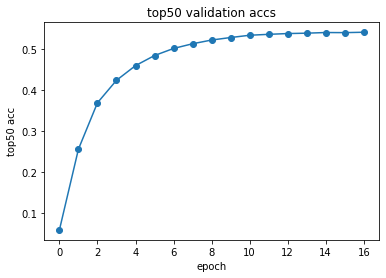

In [22]:
plt.plot(val_accs_rec["top50 acc"], "o-")
plt.title("top50 validation accs")
plt.xlabel("epoch")
plt.ylabel("top50 acc")
plt.show()

In [24]:
model = TestModel(
    num_users = num_users,
    num_items = num_items,
    embedding_size=256,
    gru_size=256,
    dense2_size=512,
    dense3_size=256,
    softmax_classes=128,
    temp=.01
)

model.load_weights("saved_weights.h5")

X_user = test_X["user_id"]
X_sess = test_X["session"]
X_sess_time = test_X["X_time"]
X_y_time = test_X["y_time"]

predictions = {}
for users, sesses, sess_times, y_times in tqdm(list(
    batchify(X_user, X_sess, X_sess_time, X_y_time, shuffle=True, batch_size=batch_size))):

    (sesses, sess_times), mask = mask_length(
        np.array(sesses),
        np.array(sess_times),
        maskon_vals=0, 
        maskoff_vals=-np.inf)

    preds, logits = model.test_step(
        tf.constant(sesses), 
        tf.constant(sess_times, np.float32),
        tf.constant(mask), 
        tf.constant(np.array(users)), 
        tf.constant(np.array(y_times, np.float32)), 
        tf.constant(np.array(y)))
    
    preds = self.call(sesses, sess_times, masks, users, y_times, training=False)
    for user, pred in zip(users, preds):
        predictions[user] = pred

embedding_size 256


ValueError: You are trying to load a weight file containing 5 layers into a model with 1 layers.

In [25]:
model.to_json()

NotImplementedError: 